# Homework 1
## Corey Nelson
### Due: 25-Sep-2017

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.


Let's try solving this by transforming the 2nd order ODE into a system of 1st order ODEs via the change of variables:
$u'(t) = v(t)$.

$$
v'(t) + av(t) + bu(t) = f(t)\\
u'(t) - v(t) = 0
$$
with the boundary conditions $u(0) = 1$ and $v(0) = 0$.

So now we need to solve a system of 1st order equations. We can modify the Chebyshev collocation technique from class to do this. 

In class, we interpolated via $T u = f$ where $T$ is the Chebyshev interpolation matrix, and we solved a laplacian via $-L u = f$ where $L$ is the second derivative interpolation matrix.

If we call the first derivative interpolation matrix $K$, then we want to solve the system:

$$ \begin{bmatrix}
     b T & K + a T\\
    K & -T \end{bmatrix}
    \begin{bmatrix} u \\ v \end{bmatrix} 
    = \begin{bmatrix} f \\ 0 \end{bmatrix} .
$$


This gives us an obvious way to apply the two boundary conditions at $t = 0$ by simply replacing the first line of of each submatrix with the corresponding boundary condition.
    

In [88]:
#SETUP. ALL FROM CLASS NOTES
%matplotlib inline
import numpy
from matplotlib import pyplot
# from class notes
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return numpy.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * numpy.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - self.x0)) * numpy.cosh(self.k*(x - self.x0))**(-2)

In [112]:
#SOLVER:
def MSD_cheb(n, rhsfunc, IC_val, IC_dir, a, b):
    """Solve the mass-spring-damping system over the time [0,1] using n time steps with rhsfunc(x) forcing.
    the initial conditions are given by the values IC_val (value of initial condition) 
    and IC_dir (derivative of initial condition).  parameters a and b are system parameters"""
    x = cosspace(0, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    K = T[1]
    T1 = T[0]
    
    #build up each of the submatrices
    A1 = b*T1
    A1[0] = T1[0]
    
    A2 = K + a* T1
    A2[0] = 0
    
    A3 = K
    A3[0] = 0
    
    A4 = -T1
    A4[0] = T1[0]
    
    #append together each of the submatrices into the operator A
    A = numpy.concatenate((A1,A2),axis=1)
    A = numpy.concatenate((A, numpy.concatenate((A3,A4),axis=1)), axis=0)
    #build rhs vector
    rhs = rhsfunc(x)
    rhs[0] = IC_val
    
    rhs  = numpy.append(rhs,IC_dir)    
    rhs = numpy.concatenate((rhs,0*x[1:]))
    #build a factor matrix to get the operator into the chebyshev basis 
    B = numpy.concatenate((T1,0*T1),axis = 1)
    B = numpy.concatenate((B, numpy.concatenate((0*T1, T1), axis = 1)), axis = 0)
    return x, A.dot(numpy.linalg.inv(B)), rhs

Let's test the solver! Here we use a $\tanh(t)$ exact solution and set the boundary conditions to $ u(0) = \tanh(0)$ and $u'(0) = \tanh'(0)$:

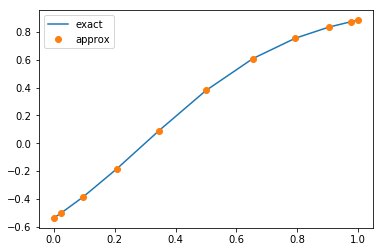

In [124]:
sol = exact_tanh(2, .3)
t, A, f = MSD_cheb(10, lambda t: sol.ddu(t) + a*sol.du(t) + b*sol.u(t), sol.u(0), sol.du(0), a, b)
u = numpy.linalg.solve(A,f)
u = u[0:len(t)]
pyplot.figure()
pyplot.plot(t,sol.u(t), label='exact')
pyplot.plot(t,u, 'o', label='approx')
pyplot.legend(loc='upper left')

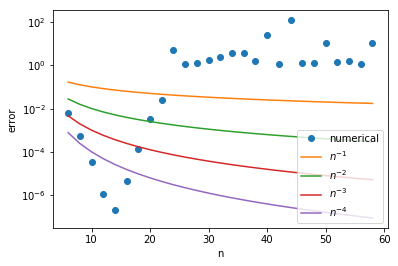

In [123]:
def mms_error(n, discretize, a, b, sol):
    t, A, f = discretize(n, lambda t: sol.ddu(t) + a*sol.du(t) + b*sol.u(t), sol.u(0),sol.du(0), a, b)
    u = numpy.linalg.solve(A, f)
    u = u[0:len(t)]
    return numpy.linalg.norm(u - sol.u(t), numpy.inf)

ex = exact_tanh(2,0.3)
a = 1
b = 1
ns = numpy.arange(6,60,2)
errors = [mms_error(n, MSD_cheb,a,b, ex) for n in ns]
pyplot.figure()
pyplot.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
    
pyplot.legend(loc='lower right');
